# Introduction
This notebook extensively outlines my experimentation in relation to the final project. The kaggle competition page states ' the primary goal isn't only to produce accurate forecasts. It’s also to identify factors that appear to impact the transmission rate of COVID-19.' In spirit of this, while mainly focusing on building a model that can forecast future numbers of covid19 cases and fatalities, I have also looked into some features that may effect the growth of the virus. For doing this, data external to the competition dataset has been utilised. 

Three additional datasets are used:
 country_info at https://www.kaggle.com/koryto/countryinfo

countrylockdowndates at https://www.kaggle.com/jcyzag/covid19-lockdown-dates-by-country

country testing data at https://www.kaggle.com/skylord/covid19-tests-conducted-by-country




##Imports

In [ ]:
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#I am using google colab, this code is getting authentication to download from my google drive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1n4nfk9A-1j_h_8RERu3rkAzBp4unDoEV'})
downloaded.GetContentFile('train.csv')
downloaded2 = drive.CreateFile({'id':'1roP_pEY5sZYWqoLCCCuKFe_tOfv_LYg9'})
downloaded2.GetContentFile('test.csv')
downloaded3 = drive.CreateFile({'id':'1EuCXjf7Nio-6a6_FsHlXLysIznt6puBi'})
downloaded3.GetContentFile('submission.csv')
downloaded4 = drive.CreateFile({'id':'1zVCvRfHgazYskZq53Cbdx1B5qM3BxNMi'})
downloaded4.GetContentFile('covid19countryinfo.csv')
downloaded5 = drive.CreateFile({'id':'1QWvKs1YbLo90b3vOyI2s6C2rszXtbZQm'})
downloaded5.GetContentFile('covid19tests.csv')

downloaded7 = drive.CreateFile({'id':'1pXNCqWL1cYsVqLod5KY7kjIzrzYgf7HE'})
downloaded7.GetContentFile('countryLockdowndatesJHUMatch.csv')

In [ ]:
testSet=pd.read_csv('test.csv')
trainSet =pd.read_csv('train.csv')
submission=pd.read_csv('submission.csv')
country_info_df=pd.read_csv('covid19countryinfo.csv')
testingInfo=pd.read_csv('covid19tests.csv')
lockdowns2=pd.read_csv('countryLockdowndatesJHUMatch.csv')

##Data Cleaning

In [ ]:
#change countries to numerical values.
from sklearn.preprocessing import LabelEncoder


countries = pd.DataFrame(trainSet, columns=['Country_Region'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
trainSet['Countries'] = labelencoder.fit_transform(trainSet['Country_Region'])

# #do the same for test set
testSet['Countries'] = labelencoder.fit_transform(testSet['Country_Region'])

#check label encoding 
trainSet['Countries'].head()

0    0
1    0
2    0
3    0
4    0
Name: Countries, dtype: int64

In [ ]:
trainSet['Date']= pd.to_datetime(trainSet['Date']) 
testSet['Date']= pd.to_datetime(testSet['Date']) 

In [ ]:
trainSet = trainSet.set_index(['Date'])
testSet = testSet.set_index(['Date'])

In [ ]:
def create_time_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [ ]:
create_time_features(trainSet).head()
create_time_features(testSet).head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2020-03-19,0,3,1,3,2020,79,19,12
2020-03-20,0,4,1,3,2020,80,20,12
2020-03-21,0,5,1,3,2020,81,21,12
2020-03-22,0,6,1,3,2020,82,22,12
2020-03-23,0,0,1,3,2020,83,23,13


In [ ]:
#helping to integrate with country_info dataset
country_info_df.loc[country_info_df['alpha2code']=='TW', ['country']] = 'Taiwan'
country_info_df.loc[country_info_df['alpha2code']=='KR', ['country']] = 'South Korea'
country_info_df.loc[country_info_df['alpha2code']=='HK', ['country']] = 'Hong Kong'
country_info_df.loc[country_info_df['alpha2code']=='HK', ['region']] = None

In [ ]:
country_info_df = country_info_df[country_info_df['region'].isnull()][['country', 'alpha2code', 'pop', 'density', 'medianage', 'urbanpop', 'tests', 'testpop']]

In [ ]:
train=pd.merge(trainSet, country_info_df, left_on = "Country_Region", right_on = "country", how = "left")
x_test=pd.merge(testSet, country_info_df, left_on = "Country_Region", right_on = "country", how = "left")

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
train['density'] = mean_imp.fit_transform(train[['density']]).ravel()
train['medianage'] = mean_imp.fit_transform(train[['medianage']]).ravel()
train['urbanpop']=mean_imp.fit_transform(train[['urbanpop']]).ravel()

x_test['density'] = mean_imp.fit_transform(x_test[['density']]).ravel()
x_test['medianage'] = mean_imp.fit_transform(x_test[['medianage']]).ravel()
x_test['urbanpop']=mean_imp.fit_transform(x_test[['urbanpop']]).ravel()

In [ ]:
Training_x = train[['Countries','dayofweek','month','dayofyear','weekofyear','density','medianage','urbanpop']]
Training_y = train[['ConfirmedCases','Fatalities']]
Test_x = x_test[['Countries','dayofweek','month','dayofyear','weekofyear','density','medianage','urbanpop']]

##Data Exploration

In [ ]:
import matplotlib.pyplot as plt

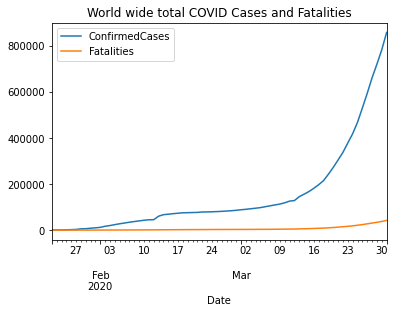

In [ ]:
#Plotting worldwide confirmed cases and fatalities, across the whole training set.
daily_analysis=train.groupby(['date']).sum()
daily_analysis[['ConfirmedCases','Fatalities']].plot()
plt.xlabel("Date")
plt.title('World wide total COVID Cases and Fatalities')
plt.savefig('worldwidecase')

In [ ]:
#Looking at individual countries

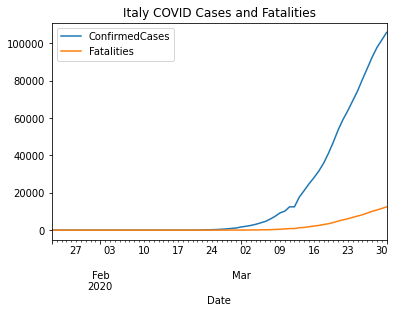

In [ ]:
italy_dat1 = train[train['Country_Region']=='Italy']
italy_dat1=italy_dat1.groupby(['date']).sum()

italy_dat1[['ConfirmedCases','Fatalities']].plot()
#italy sees and exponential growth in confirmed cases.
plt.xlabel("Date")
plt.title('Italy COVID Cases and Fatalities')
plt.savefig('Italy')

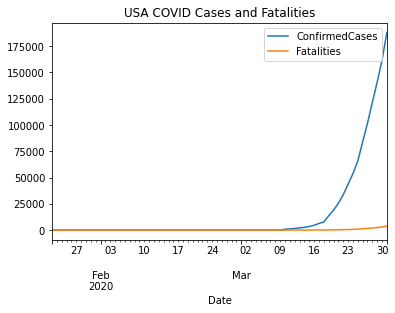

In [ ]:
US_dat1 = train[train['Country_Region']=='US']

US1=US_dat1.groupby(['date']).sum()
US1[['ConfirmedCases','Fatalities']].plot()
#US sees also sees an exponential curve.
plt.xlabel("Date")
plt.title('USA COVID Cases and Fatalities')
plt.savefig('USA')

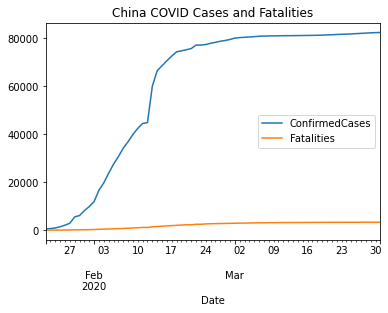

In [ ]:
China_dat1 = train[train['Country_Region']=='China']

China1=China_dat1.groupby(['date']).sum()
China1[['ConfirmedCases','Fatalities']].plot()
#China has a strange growth in confirmed cases that seems to instantly stop growing, suspicious.
plt.xlabel("Date")
plt.title('China COVID Cases and Fatalities')
plt.savefig('China')

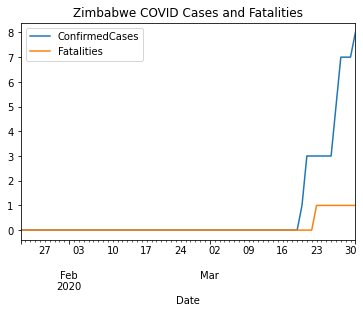

In [ ]:
Zim = train[train['Country_Region']=='Zimbabwe']

Zim=Zim.groupby(['date']).sum()
Zim[['ConfirmedCases','Fatalities']].plot()
plt.xlabel("Date")
plt.title('Zimbabwe COVID Cases and Fatalities')
plt.savefig('Zim')

In countries where a breakout has occured, we see an exponential growth in confirmed cases and fatalities. China is an outlier in this regard. 
Many countries (such as zimbabwe as shown) by this time in Feb-March where the training data is from, has not experienced many cases yet.

In [ ]:
train['ConfirmedCases'].mean()

514.9391156462585

In [ ]:
train['ConfirmedCases'].mode()

0    0.0
dtype: float64

In [ ]:
train['ConfirmedCases'].max()

105792.0

Also, as many countries took a considerable time to see any growth in cases, most of the data is at low numbers, a model could fit the training set to just be near 0 cases and fatalities and it would seem like a reasonable fit. 

In [ ]:
#Data explore. tik
#Build first Models, then see problem.
#Feature importance from XGBoost
#Trying to fit individual country with taking log test
#Fitting from every country with XGboost, seeing problem.
#Fitting with linear for great result.

#Looking into factors important to the spread of COVID-19 

In [ ]:
lockdowns2=pd.read_csv('countryLockdowndatesJHUMatch.csv')

lockdowns2['Date']=pd.to_datetime(lockdowns2['Date'])
lockdowns2['Date'] = lockdowns2['Date'].dt.dayofyear
lockdowns2=lockdowns2.rename(columns={"Date":"DAYS SINCE"})

In [ ]:
lockdowns2.head()

,Country/Region,DAYS SINCE,Type,Reference
0,Mainland China,23.0,Full,https://en.wikipedia.org/wiki/2019%E2%80%9320_...
1,Hong Kong,83.0,Full,https://en.wikipedia.org/wiki/2020_coronavirus...
2,Macau,26.0,Full,https://en.wikipedia.org/wiki/2020_coronavirus...
3,Taiwan,33.0,Full,https://en.wikipedia.org/wiki/2020_coronavirus...
4,US,83.0,Partial,https://en.wikipedia.org/wiki/2020_coronavirus...


In [ ]:
lock=pd.merge(train, lockdowns2, left_on = "Country_Region", right_on = "Country/Region", how = "left")

In [ ]:
TrainxN = lock[['Countries','dayofweek','month','dayofyear','weekofyear','density','medianage','urbanpop','DAYS SINCE']]

In [ ]:
from xgboost import XGBRegressor

In [ ]:
XGN=XGBRegressor(objective ='reg:squarederror',n_estimators=1000)

In [ ]:
yf=train["Fatalities"]
yc=train["ConfirmedCases"]

In [ ]:
XGN.fit(TrainxN, yf, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
from xgboost import plot_importance, plot_tree

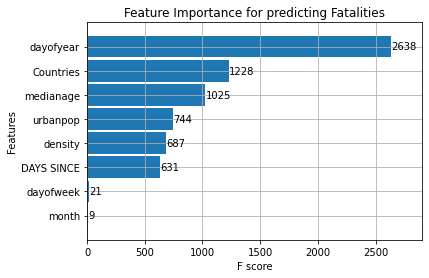

In [ ]:
plot = plot_importance(XGN, height=0.9, max_num_features=20)
plt.title('Feature Importance for predicting Fatalities')
plt.savefig('feature importance')
#Importance of features for predicting Fatalities

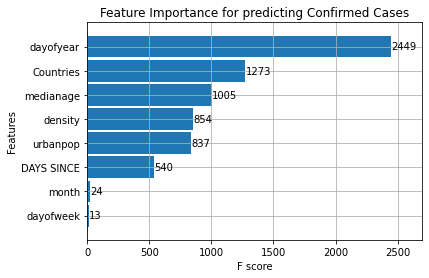

In [ ]:
XGN.fit(TrainxN, yc, verbose=True)

plot = plot_importance(XGN, height=0.9, max_num_features=20)
plt.title('Feature Importance for predicting Confirmed Cases')
plt.savefig('feature importance2')
#importance of features for predicting Confirmed Cases

As dayofyear is used as the x co-ordinate in an exponential growth, it makes sense that it sees the largest feature importance. 

Countries being in different stages of their respective outbreaks, and with different governmental responses and healthcare systems, alongside many other factors, as expected play an important part in predicting both cases and fatalities

We know that older people are more vunerable to the virus, and this was confirmed by its relative importance as a feature

Density and urban pop (Urban pop being the % of the population living in an urban environment) are features you would expect to see large correlations with eachother, and as such they have relatively equal importance across both predictions. 

Rather surprisingly, the day of the year which a country started lockdown, named DAYS SINCE, has very little correlation with prediction. 

I believe this may be explained by the fact that as this data was earlier in the year, many countries had not yet started a lockdown, scewing its importance. Also for countries that had instituted a lockdown, it needs time for there to be a relative response in confirmed cases as the amount of testing would be rapidly increasing in this time.

#Premilinary Model Building

In [ ]:
#Defining the equation used that Kaggle competition rates model on, RMSLE
def RMSLE(pred,actual):
    return np.sqrt(np.mean(np.power((np.log(pred+1)-np.log(actual+1)),2)))

In [ ]:
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

##Linear Regression

In [ ]:
LinMod1= LinearRegression()
y_vals1=cross_val_predict(LinMod1,Training_x,Training_y,cv=5)
RMSLE(y_vals1,Training_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


ConfirmedCases    4.864068
Fatalities        3.187960
dtype: float64

##Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
DTreeMod = DecisionTreeRegressor()
y_vals2=cross_val_predict(DTreeMod,Training_x,Training_y,cv=5)
RMSLE(y_vals2,Training_y)

ConfirmedCases    3.232516
Fatalities        2.144024
dtype: float64

##Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RForMod = RandomForestRegressor()
y_vals3=cross_val_predict(RForMod,Training_x,Training_y,cv=5)
RMSLE(y_vals3,Training_y)

ConfirmedCases    3.363538
Fatalities        2.178843
dtype: float64

##Linear Support vector machine

In [ ]:
#linearSVM only supports a 1d output. The regressor chain lets us predict both values while also fitting data well
from sklearn.multioutput import RegressorChain
from sklearn.svm import LinearSVR

model4 = LinearSVR()
wrapper1 = RegressorChain(model4)


y_vals4=cross_val_predict(wrapper1,Training_x,Training_y,cv=5)
RMSLE(y_vals4,Training_y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

ConfirmedCases    2.623372
Fatalities        1.279459
dtype: float64

In [ ]:
Training_y['Fatalities'].max()

12428.0

In [ ]:
svrrvals=pd.DataFrame(y_vals4)

In [ ]:
svrrvals[0].max()

50.71314888637507

In [ ]:
##Uploading initial linearSVM model to kaggle

##Uploading initial linearSVM model to kaggle

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
LinSVR = LinearSVR()
wrapperSVR = MultiOutputRegressor(LinSVR)

In [ ]:
wrapperSVR.fit(Training_x,Training_y)
vals = wrapperSVR.predict(Test_x)
preds=pd.DataFrame(vals)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
preds[0].max()

392.521486845336

In [ ]:
submits=submission[["ForecastId"]]

In [ ]:
Final_submission = pd.concat([preds,submits],axis=1)
Final_submission.columns = ['ConfirmedCases', 'Fatalities', 'ForecastId']
Final_submission1 = Final_submission[['ForecastId','ConfirmedCases', 'Fatalities']]
Final_submission1.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,11.908480,-0.291921
1,2,12.872632,-0.225264
2,3,13.836784,-0.158608
3,4,14.800936,-0.091951
4,5,14.931566,-0.016775


In [ ]:
Final_submission1["ConfirmedCases"] = Final_submission1["ConfirmedCases"].astype(int)
Final_submission1["Fatalities"] = Final_submission1["Fatalities"].astype(int)

In [ ]:
Final_submission1.to_csv("submission30.csv",index=False)

LinearSVM Produced a rmsle of 2.50902 on the test data. (From Kaggle). We see our max predicted number of cases is only 236, extremely low. 


This initial fitting across all countries is naive- Considering most of the 173 countries in the dataset had no yet experienced an outbreak, this is heavily scewing models to produce extremely low confirmed case and fatality predictions. We will have to fit for individual countries

#Trying to fit individual countries

In [ ]:
country_data = train[train['Country_Region']=='Italy']
italydat=country_data
country_data = country_data.drop(['Id','Province_State'], axis=1)
country_data = pd.pivot_table(country_data, values=['ConfirmedCases','Fatalities'], index=['date'], aggfunc=np.sum)
country_data.tail()

,ConfirmedCases,Fatalities
date,,
2020-03-27,86498.0,9134.0
2020-03-28,92472.0,10023.0
2020-03-29,97689.0,10779.0
2020-03-30,101739.0,11591.0
2020-03-31,105792.0,12428.0


In [ ]:
train['Country_Region'].value_counts()

US                        3780
China                     2310
France                     700
Canada                     700
Australia                  560
                          ... 
Eritrea                     70
Tanzania                    70
Kyrgyzstan                  70
Bosnia and Herzegovina      70
Taiwan*                     70
Name: Country_Region, Length: 173, dtype: int64

In [ ]:
italydat_x=italydat[['Countries','dayofweek','month','dayofyear','weekofyear','density','medianage','urbanpop']]

In [ ]:
from numpy import *

In [ ]:
italydat_y=italydat[['ConfirmedCases','Fatalities']]

Because we have exponential growth, I will take the log of the y data to hopefully produce a straight line that can then be fitted.

In [ ]:
logI_y=italydat_y.apply(lambda x: np.log(x))
#logI_y[isneginf(logI_y)]=0
logI_y.replace([np.inf, -np.inf], 0, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
from sklearn.multioutput import RegressorChain
from sklearn.svm import LinearSVR

italymod = LinearSVR()
italywrap = RegressorChain(italymod)


y_italy1=cross_val_predict(italywrap,italydat_x,logI_y,cv=5)
RMSLE(y_italy1,logI_y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

ConfirmedCases    0.592166
Fatalities        0.675436
dtype: float64

We see low RMSLE values when fitting the straight line

In [ ]:
#Im now taking the exponential of that straight line fit to get us back to normal scale.
y_italy1=np.exp(y_italy1)
y_italy1=pd.DataFrame(y_italy1)
x_it = range(len(y_italy1.index))
y_it = y_italy1[0]


#x_data5 = range(len(country_data5.index))
#y_data5 = country_data5['ConfirmedCases']

In [ ]:

x_data = range(len(italydat.index))
y_data = italydat['ConfirmedCases']

<function matplotlib.pyplot.show>

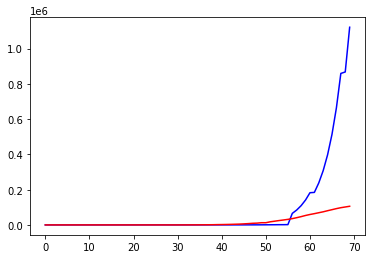

In [ ]:
plt.figure()

plt.plot(x_it,y_it,'b')
plt.plot(x_data,y_data,'r')

plt.show

We can see that while we fit the data well when using a straight line, after we convert back by using the exponential, we see that there is a terrible discrepancy in values between the fit and the real data. This method clearly does not work.

##Trying to fit with logistic regression

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


In [ ]:
logregmod3=LogisticRegression(max_iter=1000)
y_italylogreg3=cross_val_predict(logregmod3,italydat_x,y_data,cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
RMSLE(y_italylogreg3,y_data)

0.44916126693160496

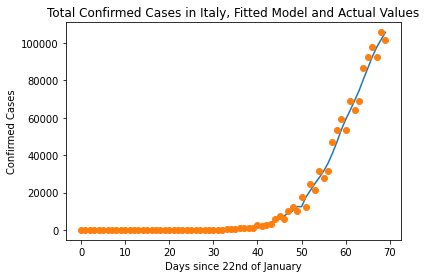

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Total Confirmed Cases in Italy, Fitted Model and Actual Values')
ax.set_ylabel('Confirmed Cases')
ax.set_xlabel('Days since 22nd of January')
ax.plot(x_data, y_data, label='Confirmed Data')
ax.plot(x_data, y_italylogreg3,'o', label='Confirmed Data')

Logisitic regression fits the training set for italy very well.

#Now doing individual fits for every country

In [ ]:
xtrain = pd.read_csv('train.csv')
xtest = pd.read_csv('test.csv')
xsubmission = pd.read_csv('submission.csv')

In [ ]:
xtrain.rename(columns={'Country_Region':'Country'}, inplace=True)
xtest.rename(columns={'Country_Region':'Country'}, inplace=True)

xtrain.rename(columns={'Province_State':'State'}, inplace=True)
xtest.rename(columns={'Province_State':'State'}, inplace=True)

xtrain['Date'] = pd.to_datetime(xtrain['Date'], infer_datetime_format=True)
xtest['Date'] = pd.to_datetime(xtest['Date'], infer_datetime_format=True)

xtrain.info()
xtest.info()

y1_xTrain = xtrain.iloc[:, -2]
y1_xTrain.head()
y2_xTrain = xtrain.iloc[:, -1]
y2_xTrain.head()

EMPTY_VAL = "EMPTY_VAL"

def fillState(state, country):
    if state == EMPTY_VAL: return country
    return state

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20580 entries, 0 to 20579
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              20580 non-null  int64         
 1   State           8750 non-null   object        
 2   Country         20580 non-null  object        
 3   Date            20580 non-null  datetime64[ns]
 4   ConfirmedCases  20580 non-null  float64       
 5   Fatalities      20580 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 964.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12642 entries, 0 to 12641
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ForecastId  12642 non-null  int64         
 1   State       5375 non-null   object        
 2   Country     12642 non-null  object        
 3   Date        12642 non-null  datetime64[n

In [ ]:
X_xTrain = xtrain.copy()

X_xTrain['State'].fillna(EMPTY_VAL, inplace=True)
X_xTrain['State'] = X_xTrain.loc[:, ['State', 'Country']].apply(lambda x : fillState(x['State'], x['Country']), axis=1)

X_xTrain.loc[:, 'Date'] = X_xTrain.Date.dt.strftime("%m%d")
X_xTrain["Date"]  = X_xTrain["Date"].astype(int)

X_xTrain.head()

#X_Test = df_test.loc[:, ['State', 'Country', 'Date']]
X_xTest = xtest.copy()

X_xTest['State'].fillna(EMPTY_VAL, inplace=True)
X_xTest['State'] = X_xTest.loc[:, ['State', 'Country']].apply(lambda x : fillState(x['State'], x['Country']), axis=1)

X_xTest.loc[:, 'Date'] = X_xTest.Date.dt.strftime("%m%d")
X_xTest["Date"]  = X_xTest["Date"].astype(int)

X_xTest.head()

,ForecastId,State,Country,Date
0,1,Afghanistan,Afghanistan,319
1,2,Afghanistan,Afghanistan,320
2,3,Afghanistan,Afghanistan,321
3,4,Afghanistan,Afghanistan,322
4,5,Afghanistan,Afghanistan,323


In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

X_xTrain.Country = le.fit_transform(X_xTrain.Country)
X_xTrain['State'] = le.fit_transform(X_xTrain['State'])

X_xTrain.head()

X_xTest.Country = le.fit_transform(X_xTest.Country)
X_xTest['State'] = le.fit_transform(X_xTest['State'])

X_xTest.head()

xtrain.head()
xtrain.loc[xtrain.Country == 'Afghanistan', :]
xtest.tail()

,ForecastId,State,Country,Date
12637,12638,NaN,Zimbabwe,2020-04-26
12638,12639,NaN,Zimbabwe,2020-04-27
12639,12640,NaN,Zimbabwe,2020-04-28
12640,12641,NaN,Zimbabwe,2020-04-29
12641,12642,NaN,Zimbabwe,2020-04-30


In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

from xgboost import XGBRegressor

countries = X_xTrain.Country.unique()

In [ ]:
xout = pd.DataFrame({'ForecastId': [], 'ConfirmedCases': [], 'Fatalities': []})

for country in countries:
    states = X_xTrain.loc[X_xTrain.Country == country, :].State.unique()
    #print(country, states)
    # check whether string is nan or not
    for state in states:
        X_xTrain_CS = X_xTrain.loc[(X_xTrain.Country == country) & (X_xTrain.State == state), ['State', 'Country', 'Date', 'ConfirmedCases', 'Fatalities']]
        
        y1_xTrain_CS = X_xTrain_CS.loc[:, 'ConfirmedCases']
        y2_xTrain_CS = X_xTrain_CS.loc[:, 'Fatalities']
        
        X_xTrain_CS = X_xTrain_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_xTrain_CS.Country = le.fit_transform(X_xTrain_CS.Country)
        X_xTrain_CS['State'] = le.fit_transform(X_xTrain_CS['State'])
        
        X_xTest_CS = X_xTest.loc[(X_xTest.Country == country) & (X_xTest.State == state), ['State', 'Country', 'Date', 'ForecastId']]
        
        X_xTest_CS_Id = X_xTest_CS.loc[:, 'ForecastId']
        X_xTest_CS = X_xTest_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_xTest_CS.Country = le.fit_transform(X_xTest_CS.Country)
        X_xTest_CS['State'] = le.fit_transform(X_xTest_CS['State'])
        
        #models_C[country] = gridSearchCV(model, X_Train_CS, y1_Train_CS, param_grid, 10, 'neg_mean_squared_error')
        #models_F[country] = gridSearchCV(model, X_Train_CS, y2_Train_CS, param_grid, 10, 'neg_mean_squared_error')
        
        xmodel1 = XGBRegressor(n_estimators=1000)
        xmodel1.fit(X_xTrain_CS, y1_xTrain_CS)
        y1_xpred = xmodel1.predict(X_xTest_CS)
        
        xmodel2 = XGBRegressor(n_estimators=1000)
        xmodel2.fit(X_xTrain_CS, y2_xTrain_CS)
        y2_xpred = xmodel2.predict(X_xTest_CS)
        
        xdata = pd.DataFrame({'ForecastId': X_xTest_CS_Id, 'ConfirmedCases': y1_xpred, 'Fatalities': y2_xpred})
        xout = pd.concat([xout, xdata], axis=0)

In [ ]:
xout.ForecastId = xout.ForecastId.astype('int')

In [ ]:
xs=xout

In [ ]:
xout['ConfirmedCases'].max()

105791.8984375

In [ ]:
train['ConfirmedCases'].max()

105792.0

In [ ]:
testsets=pd.concat([x_test, xs], axis=1)

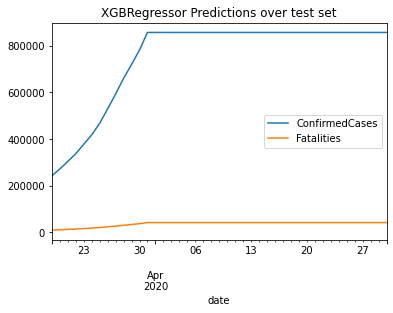

In [ ]:
#plotting global total confirmed cases and fatalities across the test set
daily_analysis=testsets.groupby(['date']).sum()
daily_analysis[['ConfirmedCases','Fatalities']].plot()

plt.title('XGBRegressor Predictions over test set')
plt.savefig('XGB')

The XGBOOST model fits over every region of every country. We see that once the model reaches a prediction of confirmed cases which is the maximum value from the test set, we do not go above that value. 
As it turns out, tree models are incapable of extrapolating. Meaning their output predictions can never contain larger values than the max value from the data set it was trained on.

While it is true that the tree models can fit the training data extremely well compared to linear fits, they are not useful for this problem as they will not extrapolate.



In [ ]:

xout.ConfirmedCases=xout.ConfirmedCases.astype('int')
xout.Fatalities=xout.Fatalities.astype('int')

In [ ]:
xout.to_csv("submission100.csv",index=False)

This model got an rmsle=1.89624 score on the test set (from kaggle). This is just marginally above kaggles 'no new cases' threshold, which is as expected for reasons explained.


#Fitting linear models to just one country.

first fitting for one country

Fitting italy data using linear regression

In [ ]:
train.head()

,Id,Province_State,Country_Region,ConfirmedCases,Fatalities,Countries,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,country,alpha2code,pop,density,medianage,urbanpop,tests,testpop
0,1,NaN,Afghanistan,0.0,0.0,0,2020-01-22,0,2,1,1,2020,22,22,4,Afghanistan,AF,"38,928,346",60.0,18.0,25.0,NaN,NaN
1,2,NaN,Afghanistan,0.0,0.0,0,2020-01-23,0,3,1,1,2020,23,23,4,Afghanistan,AF,"38,928,346",60.0,18.0,25.0,NaN,NaN
2,3,NaN,Afghanistan,0.0,0.0,0,2020-01-24,0,4,1,1,2020,24,24,4,Afghanistan,AF,"38,928,346",60.0,18.0,25.0,NaN,NaN
3,4,NaN,Afghanistan,0.0,0.0,0,2020-01-25,0,5,1,1,2020,25,25,4,Afghanistan,AF,"38,928,346",60.0,18.0,25.0,NaN,NaN
4,5,NaN,Afghanistan,0.0,0.0,0,2020-01-26,0,6,1,1,2020,26,26,4,Afghanistan,AF,"38,928,346",60.0,18.0,25.0,NaN,NaN


In [ ]:
global_data  =trainSet
country_data = global_data[global_data['Country_Region']=='Italy']
italydat=country_data

In [ ]:
italydat_x=italydat[['date','Id']]
italydat_y=italydat[['ConfirmedCases','Fatalities']]

In [ ]:
y_italy1=italydat_y['ConfirmedCases']

In [ ]:
x = range(len(y_italy1.index))
x=np.array(x)[:,None]
y_it = y_italy1

In [ ]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show>

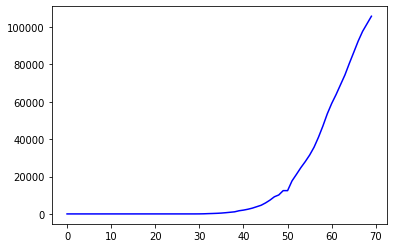

In [ ]:
plt.figure()

plt.plot(x,y_it,'b')

plt.show

In [ ]:
x.shape

(70, 1)

We save the x matrix, along with x^2, x^3,x^4 so that Linear Regression can fit polynomial coefficients.

In [ ]:
x_new=np.hstack([x,x**2,x**3,x**4])

In [ ]:
x_new.shape

(70, 4)

In [ ]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(x_new,y_it)
model.coef_


array([ 6.07247773e+02, -3.32304765e+01,  2.42476198e-01,  6.72569501e-03])

In [ ]:
ypred=model.predict(x_new)

<function matplotlib.pyplot.show>

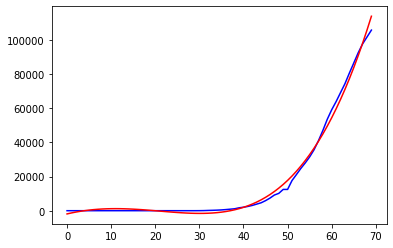

In [ ]:
plt.figure()

plt.plot(x,y_it,'b')
plt.plot(x_new[:,0],ypred,'r')
plt.show

In [ ]:
#This method is working great, will now run it across every province as was done for xgboost.

#Building the Final Model

Running the same code for the XG boost model that fit over every country, but now with the linear regression method that was just shown.

In [ ]:

xtrain = pd.read_csv('train.csv')
xtest = pd.read_csv('test.csv')
xsubmission = pd.read_csv('submission.csv')

In [ ]:
xtrain.rename(columns={'Country_Region':'Country'}, inplace=True)
xtest.rename(columns={'Country_Region':'Country'}, inplace=True)

xtrain.rename(columns={'Province_State':'State'}, inplace=True)
xtest.rename(columns={'Province_State':'State'}, inplace=True)

xtrain['Date'] = pd.to_datetime(xtrain['Date'], infer_datetime_format=True)
xtest['Date'] = pd.to_datetime(xtest['Date'], infer_datetime_format=True)

xtrain.info()
xtest.info()

y1_xTrain = xtrain.iloc[:, -2]
y1_xTrain.head()
y2_xTrain = xtrain.iloc[:, -1]
y2_xTrain.head()

EMPTY_VAL = "EMPTY_VAL"

def fillState(state, country):
    if state == EMPTY_VAL: return country
    return state

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20580 entries, 0 to 20579
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              20580 non-null  int64         
 1   State           8750 non-null   object        
 2   Country         20580 non-null  object        
 3   Date            20580 non-null  datetime64[ns]
 4   ConfirmedCases  20580 non-null  float64       
 5   Fatalities      20580 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 964.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12642 entries, 0 to 12641
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ForecastId  12642 non-null  int64         
 1   State       5375 non-null   object        
 2   Country     12642 non-null  object        
 3   Date        12642 non-null  datetime64[n

In [ ]:
X_xTrain = xtrain.copy()

X_xTrain['State'].fillna(EMPTY_VAL, inplace=True)
X_xTrain['State'] = X_xTrain.loc[:, ['State', 'Country']].apply(lambda x : fillState(x['State'], x['Country']), axis=1)

X_xTrain.loc[:, 'Date'] = X_xTrain.Date.dt.dayofyear
X_xTrain["Date"]  = X_xTrain["Date"].astype(int)

X_xTrain.head()

#X_Test = df_test.loc[:, ['State', 'Country', 'Date']]
X_xTest = xtest.copy()

X_xTest['State'].fillna(EMPTY_VAL, inplace=True)
X_xTest['State'] = X_xTest.loc[:, ['State', 'Country']].apply(lambda x : fillState(x['State'], x['Country']), axis=1)

X_xTest.loc[:, 'Date'] = X_xTest.Date.dt.dayofyear
X_xTest["Date"]  = X_xTest["Date"].astype(int)

X_xTest.head()

,ForecastId,State,Country,Date
0,1,Afghanistan,Afghanistan,79
1,2,Afghanistan,Afghanistan,80
2,3,Afghanistan,Afghanistan,81
3,4,Afghanistan,Afghanistan,82
4,5,Afghanistan,Afghanistan,83


In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

from xgboost import XGBRegressor

countries = X_xTrain.Country.unique()
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
xout = pd.DataFrame({'ForecastId': [], 'ConfirmedCases': [], 'Fatalities': []})

for country in countries:
    states = X_xTrain.loc[X_xTrain.Country == country, :].State.unique()
    #print(country, states)
    # check whether string is nan or not
    for state in states:
        X_xTrain_CS = X_xTrain.loc[(X_xTrain.Country == country) & (X_xTrain.State == state), ['State', 'Country', 'Date', 'ConfirmedCases', 'Fatalities']]
        
        y1_xTrain_CS = X_xTrain_CS.loc[:, 'ConfirmedCases']
        y2_xTrain_CS = X_xTrain_CS.loc[:, 'Fatalities']
        
        X_xTrain_CS = X_xTrain_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_xTrain_CS.Country = le.fit_transform(X_xTrain_CS.Country)
        X_xTrain_CS['State'] = le.fit_transform(X_xTrain_CS['State'])
        

        X_xTest_CS = X_xTest.loc[(X_xTest.Country == country) & (X_xTest.State == state), ['State', 'Country', 'Date', 'ForecastId']]
        


        X_xTest_CS_Id = X_xTest_CS.loc[:, 'ForecastId']
        X_xTest_CS = X_xTest_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_xTest_CS.Country = le.fit_transform(X_xTest_CS.Country)
        X_xTest_CS['State'] = le.fit_transform(X_xTest_CS['State'])
        
        #models_C[country] = gridSearchCV(model, X_Train_CS, y1_Train_CS, param_grid, 10, 'neg_mean_squared_error')
        #models_F[country] = gridSearchCV(model, X_Train_CS, y2_Train_CS, param_grid, 10, 'neg_mean_squared_error')
        x2new=np.hstack([X_xTrain_CS,X_xTrain_CS**2,X_xTrain_CS**3,X_xTrain_CS**4])
        ynew=np.hstack([X_xTest_CS,X_xTest_CS**2,X_xTest_CS**3,X_xTest_CS**4])


        xmodel1=LinearRegression()
        xmodel1.fit(x2new,y1_xTrain_CS)
        y1_xpred=xmodel1.predict(ynew)
        
        x2new=np.hstack([X_xTrain_CS,X_xTrain_CS**2,X_xTrain_CS**3,X_xTrain_CS**4])
        xmodel2=LinearRegression()
        xmodel2.fit(x2new,y2_xTrain_CS)
        y2_xpred=xmodel2.predict(ynew)

        
        xdata = pd.DataFrame({'ForecastId': X_xTest_CS_Id, 'ConfirmedCases': y1_xpred, 'Fatalities': y2_xpred})
        xout = pd.concat([xout, xdata], axis=0)

In [ ]:
xout

,ForecastId,ConfirmedCases,Fatalities
0,1.0,28.635193,0.516439
1,2.0,34.813857,0.697919
2,3.0,41.787123,0.905777
3,4.0,49.611657,1.141978
4,5.0,58.345887,1.408546
...,...,...,...
12637,12638.0,74.240164,10.552996
12638,12639.0,79.024043,11.206736
12639,12640.0,84.029000,11.889559
12640,12641.0,89.261573,12.602294


In [ ]:
xout.ForecastId = xout.ForecastId.astype('int')
xout.ConfirmedCases=xout.ConfirmedCases.astype('int')
xout.Fatalities=xout.Fatalities.astype('int')

In [ ]:
xtout=xout.copy()

In [ ]:
xtout[xtout < 0] = 0

#Results from the Final Model

In [ ]:
xtout

,ForecastId,ConfirmedCases,Fatalities
0,1,28,0
1,2,34,0
2,3,41,0
3,4,49,1
4,5,58,1
...,...,...,...
12637,12638,74,10
12638,12639,79,11
12639,12640,84,11
12640,12641,89,12


In [ ]:
xtout.to_csv("submission116.csv",index=False)

This model recieved a great score of rmsle=0.25852 on kaggle!! 
This is by far the best score we have received during modelling, of course far out performing the XGBoost model that was incapable of extrapolation.

In [ ]:
xtout['ConfirmedCases'].max()

962662

In [ ]:
xtout['ConfirmedCases'].min()

0

In [ ]:
testsets=pd.concat([xtest, xtout], axis=1)

Now Looking at the predictions that the model has made

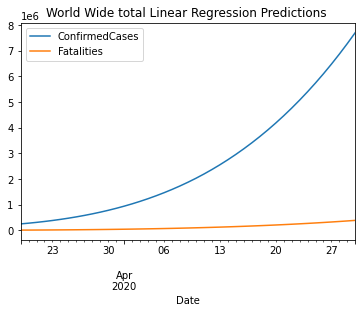

In [ ]:
#World wide total cases
daily_analysis=testsets.groupby(['Date']).sum()
daily_analysis[['ConfirmedCases','Fatalities']].plot()
plt.title('World Wide total Linear Regression Predictions ')
plt.savefig('LINREG')

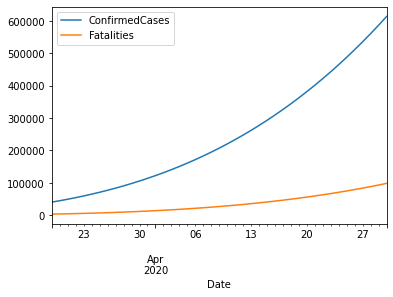

In [ ]:
#prediction of the progression of COVID in italy
italy_dat = testsets[testsets['Country']=='Italy']
italy_dat=italy_dat.groupby(['Date']).sum()
italy_dat[['ConfirmedCases','Fatalities']].plot()

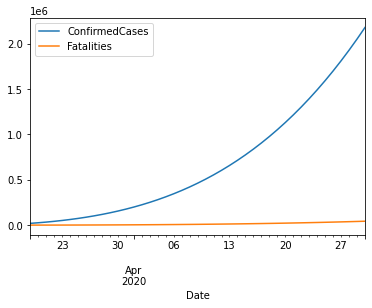

In [ ]:
#prediction of the progression of COVID in US
US_dat = testsets[testsets['Country']=='US']

US=US_dat.groupby(['Date']).sum()
US[['ConfirmedCases','Fatalities']].plot()

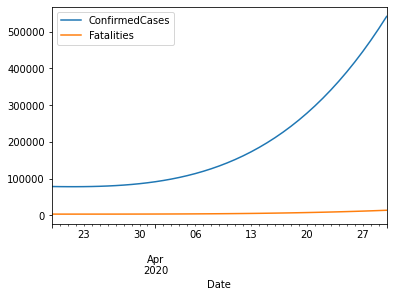

In [ ]:
#prediction of the progression of COVID in China
China_dat = testsets[testsets['Country']=='China']

China=China_dat.groupby(['Date']).sum()
China[['ConfirmedCases','Fatalities']].plot()

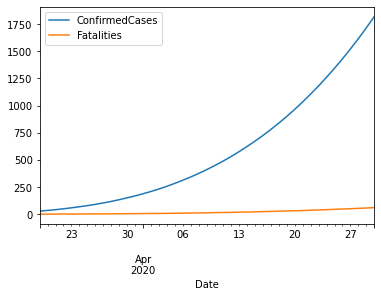

In [ ]:
#prediction of the progression of COVID in Afghanistan
Afghan_dat = testsets[testsets['Country']=='Afghanistan']

Afghan=Afghan_dat.groupby(['Date']).sum()
Afghan[['ConfirmedCases','Fatalities']].plot()